In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors

%matplotlib inline

In [2]:
# Functions

def symbol_to_path(symbol, base_dir = 'data'):
    '''Return CSV file path given ticker symbol'''
    return os.path.join(base_dir, '{}.csv'.format(str(symbol)))

def get_data(symbols, dates):
    '''Read stock data (adjusted close) given symbols, from CSV files'''
    df = pd.DataFrame(index = dates)
    if 'SPY' not in symbols:  # Add SPY for reference, if absent
        symbols.insert(0,'SPY')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), 
                          index_col = 'Date', 
                          parse_dates = True, 
                          usecols = ['Date', 'Adj Close'], 
                          na_values = ['nan'])
        df_temp = df_temp.rename(columns = {'Adj Close': symbol})
        df = df.join(df_temp)
        if symbol == 'SPY': # drop dates SPY did not trade
            df = df.dropna(subset=['SPY'])
    return df

def plot_data(df, title = 'Stock prices', ylabel = 'Price'):
    '''Plot stock prices'''
    ax = df.plot(title = title, fontsize = 12)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    plt.show()
    
def get_bollinger_bands(rm, rstd):
    '''Return upper and lower Bollinger bands'''
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return upper_band, lower_band

def get_rolling_mean(df, window):
    return pd.rolling_mean(df, window = window)

def get_rolling_std(df, window):
    return pd.rolling_std(df, window = window)

def compute_daily_returns(df):
    '''Compute and return daily return values using pandas'''
    daily_returns = (df / df.shift(1)) - 1 # pandas shifts *back*
    daily_returns.ix[0,:] = 0 # pandas puts NaNs in row 0
    return daily_returns

def compute_cumulative_returns(df):
    '''Compute and return cumulative return values'''
    cum_returns = df.copy() # copy dataframe to match size, rows and columns
    cum_returns = (df/df.ix[0,:].values) - 1
    return cum_returns

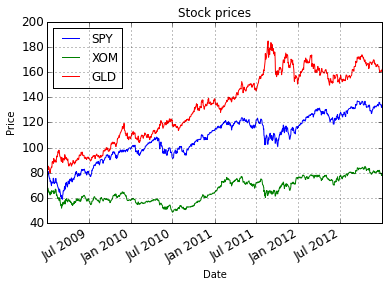

0.855601229536 -0.000260218675828


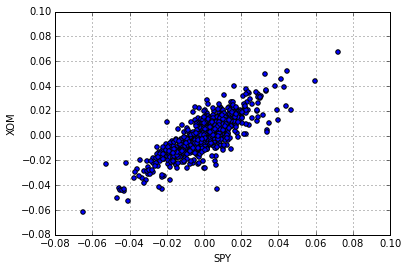

In [3]:
dates = pd.date_range('2009-01-01', '2012-12-31')
symbols = ['SPY', 'XOM', 'GLD']

df = get_data(symbols, dates)
plot_data(df)

daily_returns = compute_daily_returns(df)
daily_returns.plot(kind = 'scatter', x = 'SPY', y = 'XOM')
beta_XOM, alpha_XOM = np.polyfit(daily_returns['SPY'], 
                                 daily_returns['XOM'],1)

print beta_XOM, alpha_XOM

In [4]:
# Linear Regression API

class LinRegLearner:
    def __init__(self):
        pass

    def train(self, X,Y):
        self.m, self.b = np.polyfit(X,Y,1)

    def query(self, X):
        Y = self.m * X + self.b
        return Y

dates = pd.date_range('2009-01-01', '2012-12-31')
symbols = ['SPY', 'XOM', 'GLD']

df = get_data(symbols, dates)
daily_returns = compute_daily_returns(df)

Xtrain, Ytrain = daily_returns['SPY'], daily_returns['XOM']

# split this into a training and testing set
Xtest = Xtrain

learner = LinRegLearner()
learner.train(Xtrain, Ytrain)
Y = learner.query(Xtest)

print learner.m, learner.b

print Y.head()

0.855601229536 -0.000260218675828
2009-01-02   -0.000260
2009-01-05   -0.001273
2009-01-06    0.005453
2009-01-07   -0.025891
2009-01-08    0.003231
Name: SPY, dtype: float64


In [7]:
# get kNN working

dates = pd.date_range('2009-01-01', '2012-12-31')
symbols = ['SPY', 'XOM', 'GLD']

df = get_data(symbols, dates)

daily_returns = compute_daily_returns(df)

Xtrain = np.matrix(daily_returns['SPY']).reshape(len(df),1)
Ytrain = np.matrix(daily_returns['XOM']).reshape(len(df),1)

# split this into a training and testing set
Xtest = Xtrain

n_neighbors = 3

knn = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn.fit(Xtrain, Ytrain)
Y = knn.predict(Xtest)

print Y[:5,]

# Do a line plot through the data by starting Xtest at one end, going to the other
# for a Y value, look up the result.

[[ 0.00244237]
 [ 0.00145581]
 [-0.00869461]
 [-0.02806604]
 [ 0.00667085]]


In [3]:
# Build kNN API

dates = pd.date_range('2009-01-01', '2012-12-31')
symbols = ['SPY', 'XOM', 'GLD']

df = get_data(symbols, dates)

daily_returns = compute_daily_returns(df)

Xtrain = np.matrix(daily_returns['SPY']).reshape(len(df),1)
Ytrain = np.matrix(daily_returns['XOM']).reshape(len(df),1)

# split this into a training and testing set
Xtest = Xtrain

class kNNLearner:
    def __init__(self, k):
        self.knn = neighbors.KNeighborsRegressor(k, weights='uniform')
        self.trained = False

    def train(self, Xtrain,Ytrain):
        if self.trained:
            raise ValueError("Already trained knnlearner")
        self.knn.fit(Xtrain, Ytrain)
        self.trained = True

    def query(self, Xtest):
        if not self.trained:
            raise ValueError("querying untrained knnlearner")
        return self.knn.predict(Xtest)

learner = kNNLearner(3)
learner.train(Xtrain, Ytrain)
Y = learner.query(Xtest)

print Y[:5,]

# Do a line plot through the data by starting Xtest at one end, going to the other
# for a Y value, look up the result.



[[ 0.00244237]
 [ 0.00145581]
 [-0.00869461]
 [-0.02806604]
 [ 0.00667085]]
